In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/')
from InterpNN1D import *
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Final 1D Interp NN


In [ ]:
###Setup the parameter for our problem
n_controls = 2
N = 11
n_steps = 50
n_qubits=1

###PAULIS are written in the NN class, do not overwrite
H_drives = np.array([PAULIS["X"],PAULIS["Y"]],dtype='cfloat')
gpu_H_drives = torch.tensor(H_drives).to(device)  ###Always pass these to functions, these are stored on gpu


def excitation(theta):
    return torch.linalg.matrix_exp(-1j/2 * theta * torch.tensor(PAULIS["Z"]))

def gpu_excitation(theta):
    return torch.linalg.matrix_exp(-1j/2 * theta * torch.tensor(PAULIS["Z"]).to(device)) ###Always pass these to functions, these are stored on gpu

dt = 0.2 ###Timestep

theta_list = torch.tensor(np.linspace(0,2*pi,5000),dtype=float).to(device)

In [ ]:
rand_model  = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)
pretrained_model  = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)
trained_pretrained_model = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)
trained_model = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)

In [ ]:
rand_model.initialize_model("/content/drive/MyDrive/XYControlRZ/BeforePretrained.pt")
pretrained_model.initialize_model("/content/drive/MyDrive/XYControlRZ/JustPretrained.pt")
trained_pretrained_model.initialize_model("/content/drive/MyDrive/XYControlRZ/Pretrained.pt")
trained_model.initialize_model("/content/drive/MyDrive/XYControlRZ/NonPretrained.pt")

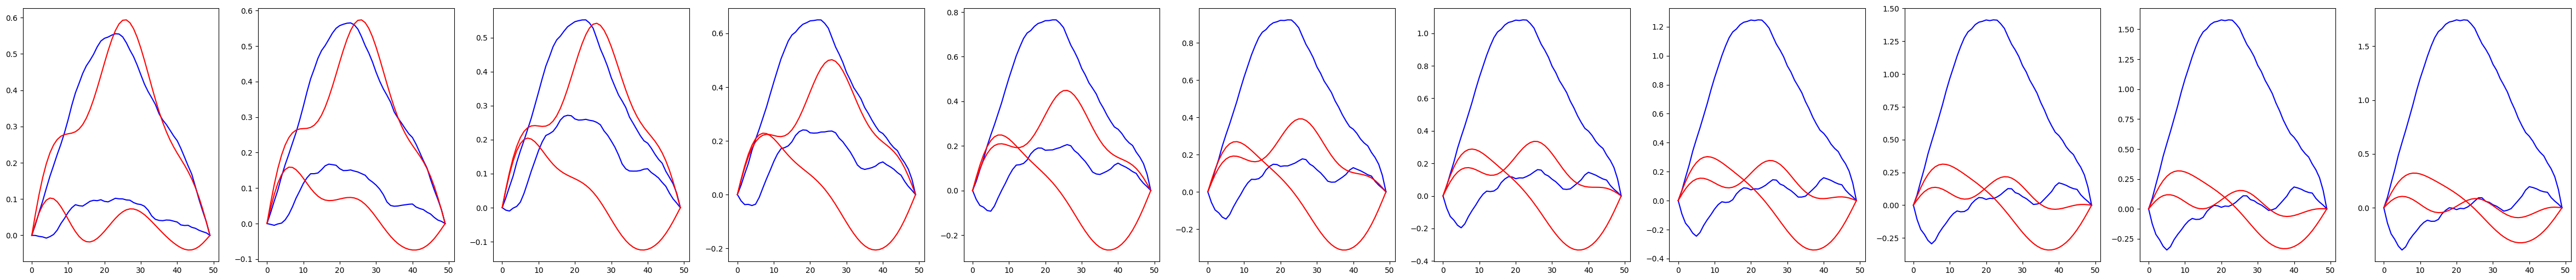

In [ ]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls1,pretrain_controls1 = rand_model.get_comparison_controls("/content/drive/MyDrive/XYControlRZ/XYControlRZGood.csv") ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls1[i],color='blue')
    ax[i].plot(pretrain_controls1[i],color='red')

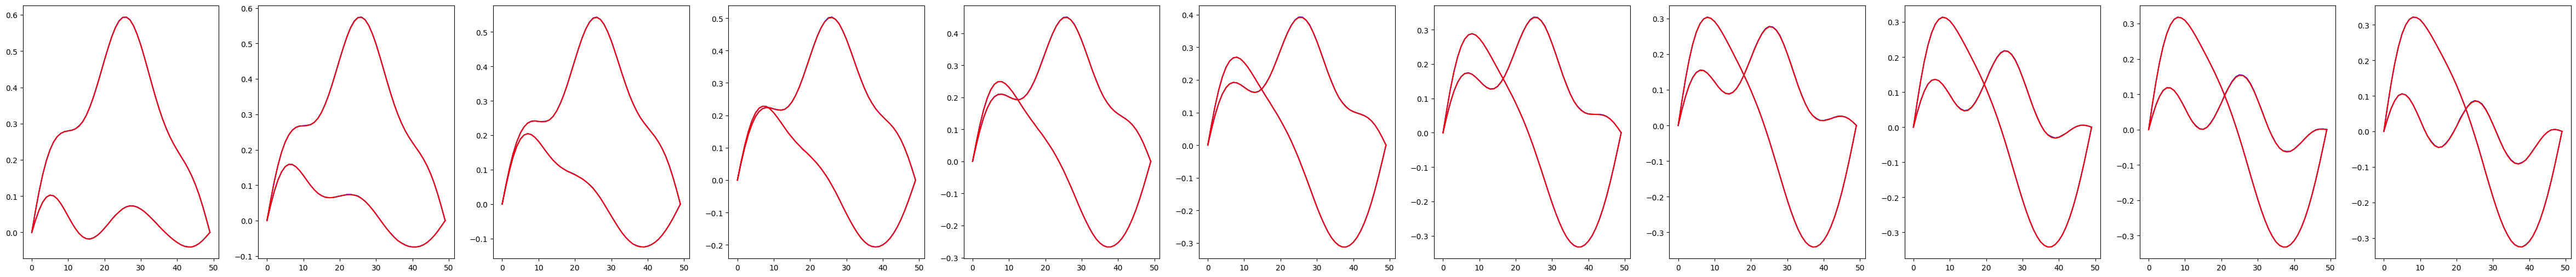

In [ ]:
fig, ax = plt.subplots(1,N,figsize=(60,6))
model_controls2,pretrain_controls2 = pretrained_model.get_comparison_controls("/content/drive/MyDrive/XYControlRZ/XYControlRZGood.csv") ###Get the model/pretrain controls
for i in range(N):
    ax[i].plot(model_controls2[i],color='blue')
    ax[i].plot(pretrain_controls2[i],color='red')

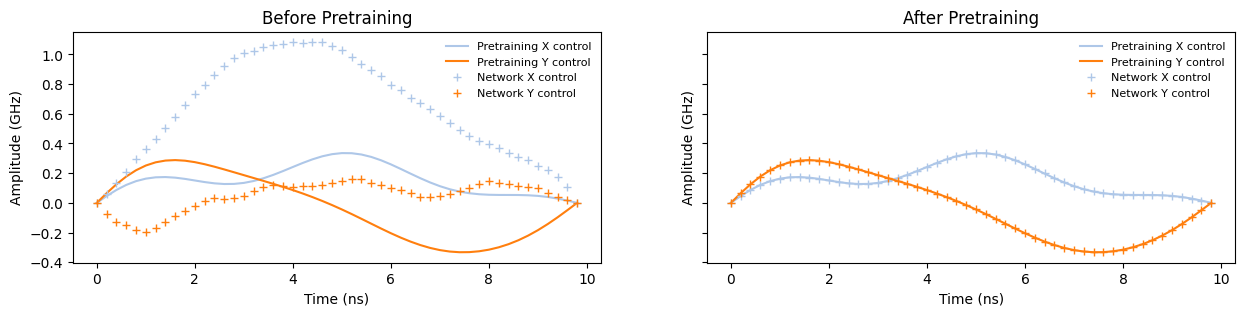

In [ ]:
c1 = plt.get_cmap("tab20")(1)
c2 = plt.get_cmap("tab20")(2)
fig, ax = plt.subplots(1,2,figsize=(15,3),sharey=True)
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls1[6].T[0],color=c1,label = "Pretraining X control")
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls1[6].T[1],color=c2,label = "Pretraining Y control")
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls1[6].T[0],'+',color=c1,label = "Network X control")
ax[0].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls1[6].T[1],'+',color=c2,label = "Network Y control")
ax[0].legend(frameon=False,prop={'size': 8})
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Amplitude (GHz)")

ax[0].set_title("Before Pretraining")

ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls2[6].T[0],color=c1,label = "Pretraining X control")
ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),pretrain_controls2[6].T[1],color=c2,label = "Pretraining Y control")
ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls2[6].T[0],'+',color=c1,label = "Network X control")
ax[1].plot(np.linspace(0,dt*(n_steps-1),n_steps),model_controls2[6].T[1],'+',color=c2,label = "Network Y control")
ax[1].legend(frameon=False,prop={'size': 8})
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Amplitude (GHz)")
ax[1].set_title("After Pretraining")
plt.savefig("/content/drive/MyDrive/Figure Storage /RZ_Pretraining_Example.pdf",format="pdf",dpi=300) #Save figure
plt.show()


In [ ]:
train_loss = pd.read_csv("/content/drive/MyDrive/XYControlRZ/Train_Loss")
test_loss = pd.read_csv("/content/drive/MyDrive/XYControlRZ/Test_Loss")

In [ ]:
pretrained_train_loss = np.array(train_loss.iloc[:,1:]).T[0]
train_loss = np.array(train_loss.iloc[:,1:]).T[1]

pretrained_test_loss = np.array(test_loss.iloc[:,1:]).T[0]
test_loss = np.array(test_loss.iloc[:,1:]).T[1]

Text(0.5, 1.0, 'Training Losses')

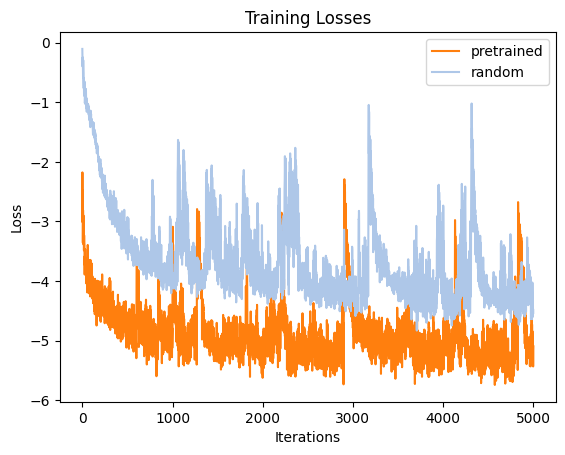

In [ ]:
plt.plot(np.log10(np.array(pretrained_train_loss)),color=c2,label='pretrained')
plt.plot(np.log10(np.array(train_loss)),color=c1,label='random')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Training Losses")

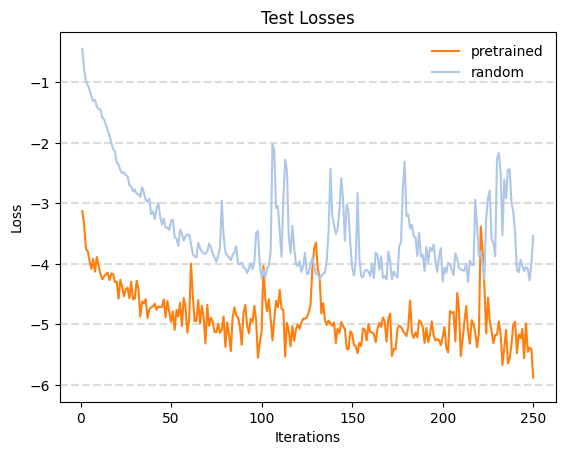

In [ ]:
new_test = [test_loss[i] for i in range(len(test_loss)) if i not in[10, 1011, 2012, 3013, 4014]]
new_test=[new_test[10*i-1] for i in range(1,500)]

pretrained_new_test = [pretrained_test_loss[i] for i in range(len(test_loss)) if i not in[10, 1011, 2012, 3013, 4014]]
pretrained_new_test=[pretrained_new_test[10*i-1] for i in range(1,500)]

for i in range(1,7):
  plt.axhline(y=-i,color='gainsboro',linestyle='--')
plt.legend(frameon=False)
plt.plot(np.array(range(1,251)),np.log10(np.array(pretrained_new_test))[:250],color=c2,label='pretrained')
plt.plot(np.array(range(1,251)),np.log10(np.array(new_test))[:250],color=c1,label='random')
plt.legend(frameon=False)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Test Losses")
plt.savefig("/content/drive/MyDrive/Figure Storage /RzTestLosses.pdf",format="pdf",dpi=300) #Save figure
plt.show()

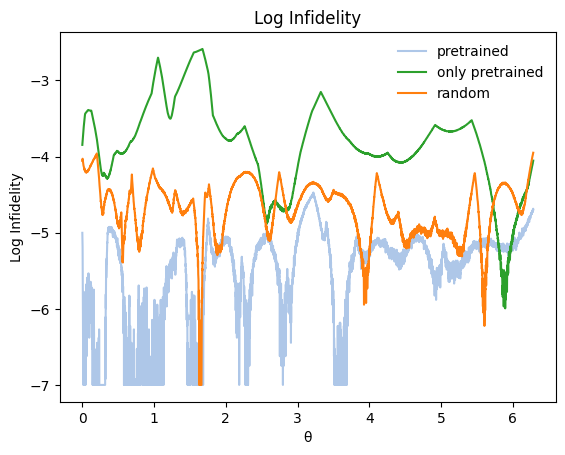

In [ ]:
log_infidelity_vals=trained_pretrained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='pretrained',color=c1)
log_infidelity_vals1=pretrained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals1).detach().numpy(),label='only pretrained',color= plt.get_cmap("tab20")(4))
log_infidelity_vals2=trained_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals2).detach().numpy(),label='random',color=c2)
plt.legend(frameon=False)
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Log Infidelity")
plt.savefig("/content/drive/MyDrive/Figure Storage /RzInfidData.pdf",format="pdf",dpi=300) #Save figure
plt.show()

In [ ]:
print(f"Pretrained: {torch.mean(10**log_infidelity_vals)}")
print(f"Non Pretrained: {torch.mean(10**log_infidelity_vals2)}")

Pretrained: 5.530349881155416e-06
Non Pretrained: 2.7068697818322107e-05


In [ ]:
print(f"Pretrained: {torch.std(10**log_infidelity_vals)}")
print(f"Non Pretrained: {torch.std(10**log_infidelity_vals2)}")

Pretrained: 5.1872898438887205e-06
Non Pretrained: 1.928359597513918e-05


In [ ]:
controls  = trained_pretrained_model.get_controls(torch.tensor([pi]).to(device))
T = torch.tensor(np.eye(2) + np.random.randn(2,2) * 0.1).float()
callibrated_controls = trained_pretrained_model.callibrated_pulses(T,torch.tensor([pi]).to(device).float())

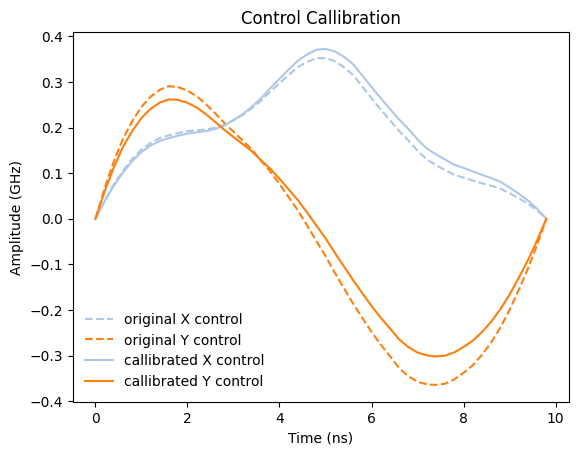

In [ ]:
plt.plot(np.linspace(0,dt*(n_steps-1),n_steps),callibrated_controls[0].detach().numpy().T[0],'--',color=c1,label='original X control')
plt.plot(np.linspace(0,dt*(n_steps-1),n_steps),callibrated_controls[0].detach().numpy().T[1],'--',color=c2,label='original Y control')

plt.plot(np.linspace(0,dt*(n_steps-1),n_steps),controls.detach().numpy().T[0],color=c1,label='callibrated X control')
plt.plot(np.linspace(0,dt*(n_steps-1),n_steps),controls.detach().numpy().T[1],color=c2,label='callibrated Y control')
plt.legend(frameon=False)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title("Control Callibration")
plt.savefig("/content/drive/MyDrive/Figure Storage /RzControlCallibration.pdf",format="pdf",dpi=300) #Save figure
plt.show()